In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def standard_scaler(data):
    scaled = []
    for d in data:
        scaled.append((d - np.mean(d))/np.std(d))
    return np.array(scaled)

In [3]:
F3path = "/s1/bhoon/dataset/cyclegan_proj/real_f3_data/real_f3_data_raw.npy"
F3 = np.load(F3path).astype(np.float32)
F3 = np.swapaxes(F3,1,2)
F3 = standard_scaler(F3)
F3.shape

(601, 128, 512)

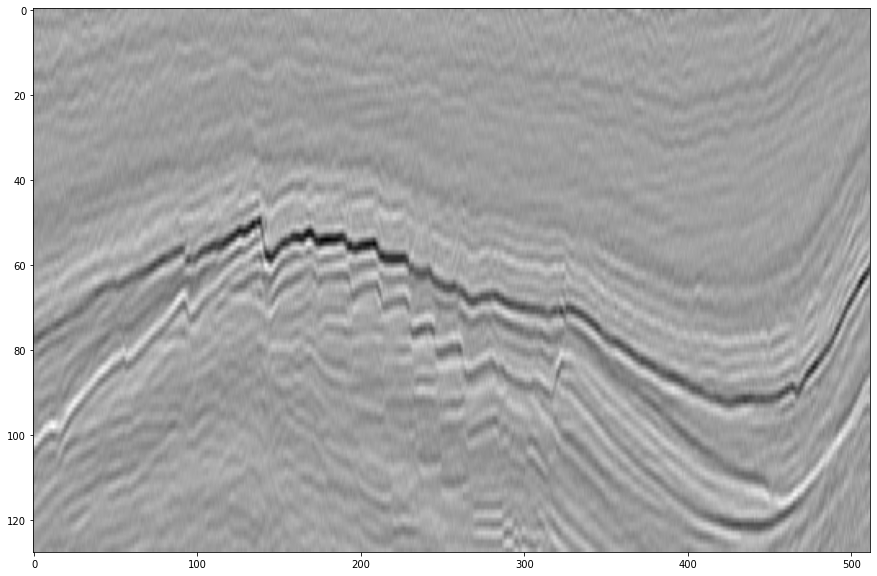

In [4]:
plt.figure(figsize=(15,10))
plt.imshow(F3[200],aspect='auto',cmap='gray')
plt.show()

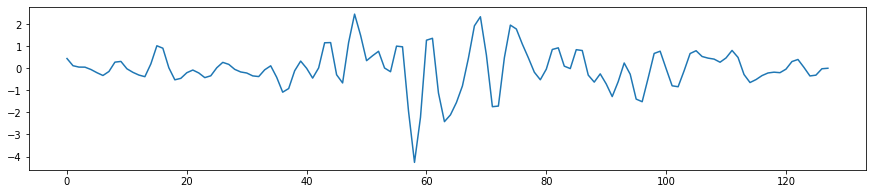

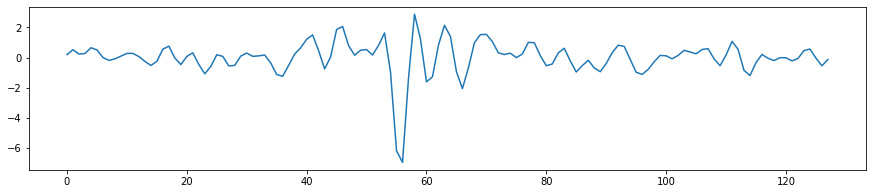

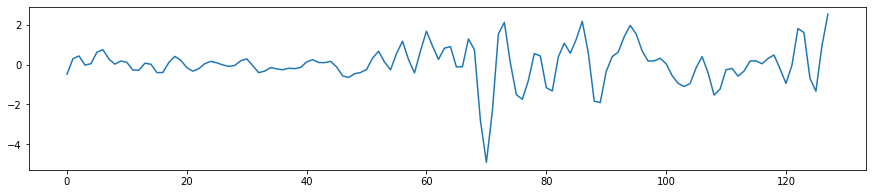

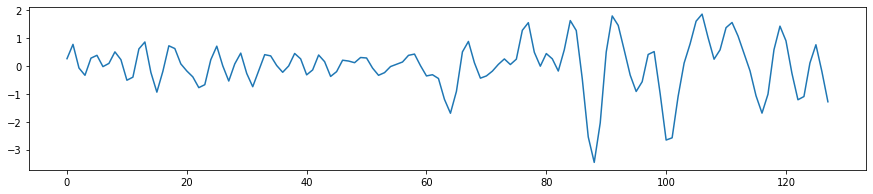

In [5]:
plt.figure(figsize=(15,3))
signal = F3[200][:,100]
plt.plot(signal)
plt.show()

plt.figure(figsize=(15,3))
signal = F3[200][:,200]
plt.plot(signal)
plt.show()

plt.figure(figsize=(15,3))
signal = F3[200][:,300]
plt.plot(signal)
plt.show()

plt.figure(figsize=(15,3))
signal = F3[200][:,400]
plt.plot(signal)
plt.show()

In [6]:
from scipy.signal import find_peaks

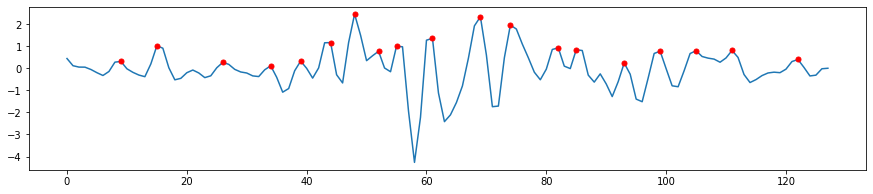

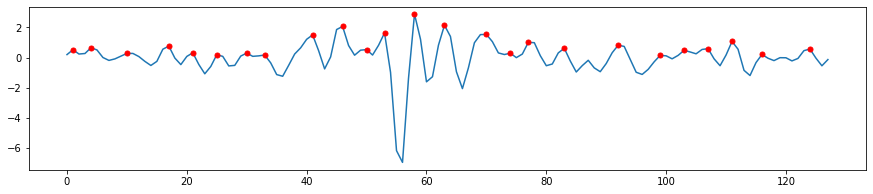

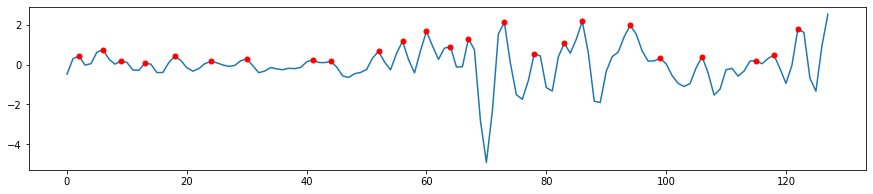

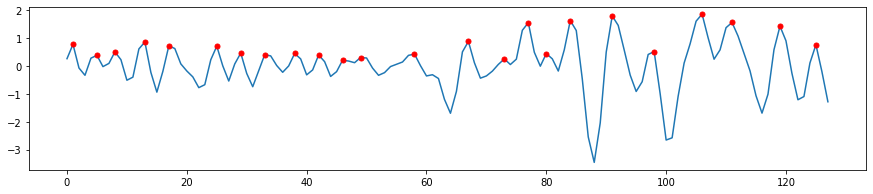

In [7]:
plt.figure(figsize=(15,3))
signal = F3[200][:,100]
peaks1, _ = find_peaks(signal, height=0)
# peaks2, _ = find_peaks(-signal, height=0)
plt.plot(signal)
plt.plot(peaks1, signal[peaks1], "o", ms=5, c='red')
# plt.plot(peaks2, signal[peaks2], "o", ms=5, c='green')
plt.show()

plt.figure(figsize=(15,3))
signal = F3[200][:,200]
peaks1, _ = find_peaks(signal, height=0)
# peaks2, _ = find_peaks(-signal, height=0)
plt.plot(signal)
plt.plot(peaks1, signal[peaks1], "o", ms=5, c='red')
# plt.plot(peaks2, signal[peaks2], "o", ms=5, c='green')
plt.show()

plt.figure(figsize=(15,3))
signal = F3[200][:,300]
peaks1, _ = find_peaks(signal, height=0)
# peaks2, _ = find_peaks(-signal, height=0)
plt.plot(signal)
plt.plot(peaks1, signal[peaks1], "o", ms=5, c='red')
# plt.plot(peaks2, signal[peaks2], "o", ms=5, c='green')
plt.show()

plt.figure(figsize=(15,3))
signal = F3[200][:,400]
peaks1, _ = find_peaks(signal, height=0)
# peaks2, _ = find_peaks(-signal, height=0)
plt.plot(signal)
plt.plot(peaks1, signal[peaks1], "o", ms=5, c='red')
# plt.plot(peaks2, signal[peaks2], "o", ms=5, c='green')
plt.show()

In [8]:
def find_peak_2d(data):
    result = data.copy()
    result[:,:] = 0
    for i in range(data.shape[1]):
        signal = data[:,i]
        peaks1, _ = find_peaks(signal, height=0)
#         peaks2, _ = find_peaks(-signal, height=0)
        result[:,i][peaks1] = 1 #data[:,i][peaks1]
#         result[:,i][peaks2] = data[:,i][peaks2]
    return result

In [9]:
peak_data = list()
for d in F3:
    peak_data.append(find_peak_2d(d))
peak_data = np.array(peak_data)

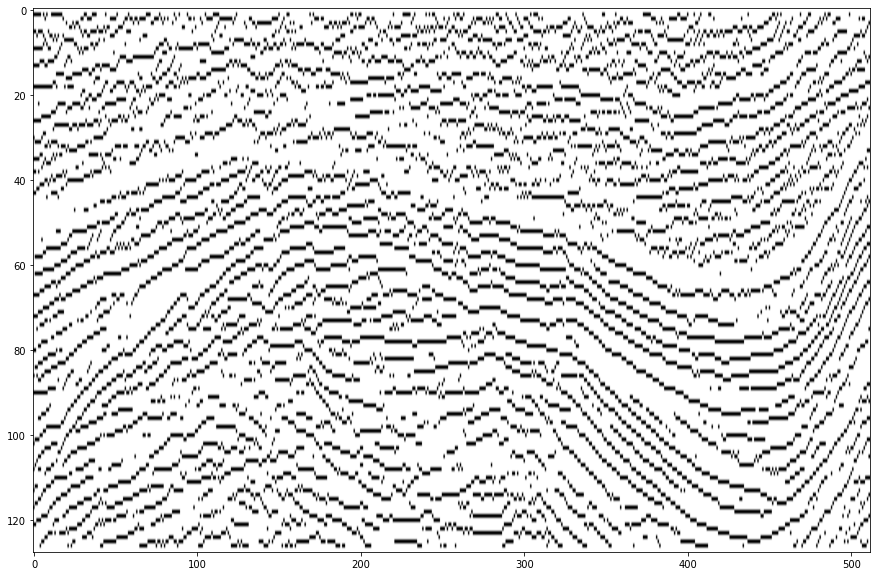

In [10]:
plt.figure(figsize=(15,10))
plt.imshow(peak_data[200],aspect='auto',cmap='Greys')
plt.show()

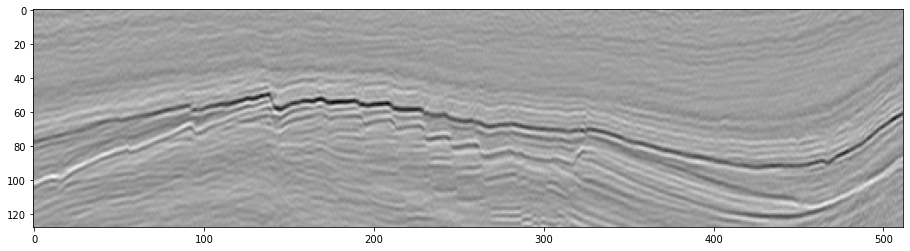

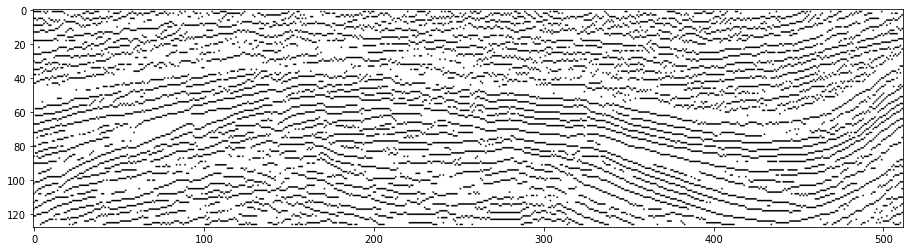

In [11]:
plt.figure(figsize=(17,4))
plt.imshow(F3[200],cmap='gray')
plt.show()

plt.figure(figsize=(17,4))
plt.imshow(peak_data[200],cmap='Greys')
plt.show()

In [12]:
def gen_patch4(arr):
    output = []  
    for i in range(len(arr)):
        output.append(arr[i][:,:128])
        output.append(arr[i][:,128:256])
        output.append(arr[i][:,256:384])
        output.append(arr[i][:,384:])
    return np.array(output)

In [13]:
F3_patch = gen_patch4(F3)
F3_patch.shape

(2404, 128, 128)

In [14]:
peak_data_patch = gen_patch4(peak_data)
peak_data_patch.shape

(2404, 128, 128)

In [15]:
np.save("/h1/bhoon/20220725_pix2pix_compare/p1/F3_Input.npy",peak_data_patch)

In [16]:
def minmax_scaler(data):
    scaled = []
    for d in data:
        scaled.append((d - np.min(d)) / (np.max(d) - np.min(d)))
    return np.array(scaled)

In [17]:
scaled_F3_patch = minmax_scaler(F3_patch)*2 -1

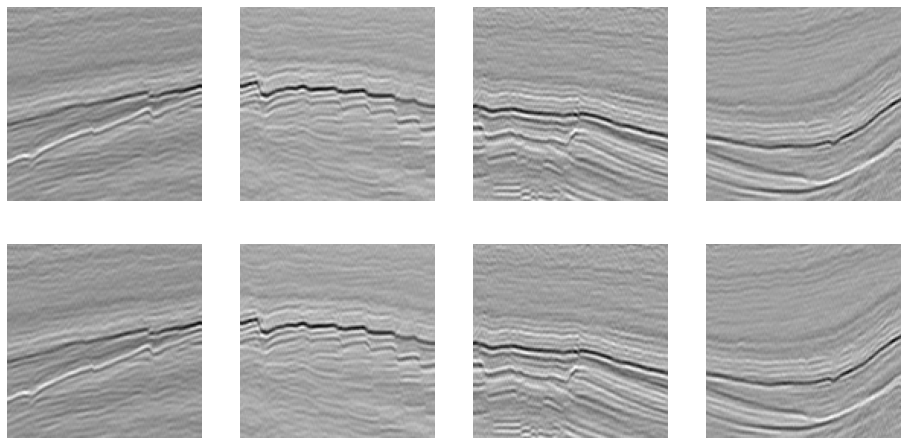

In [18]:
fig, ax = plt.subplots(2,4,figsize=(16,8))
for i in range(2):
    for j in range(4):
        if i == 0:
            ax[i,j].imshow(F3_patch[200*4+j],cmap='gray')
        if i == 1:
            ax[i,j].imshow(scaled_F3_patch[200*4+j],cmap='gray')
        ax[i,j].axis("off")

In [19]:
SPLIT = 5
data_idx  = np.arange(len(scaled_F3_patch))
valid_idx  = data_idx[::SPLIT]
train_idx = np.delete(data_idx, valid_idx)

In [20]:
trainGT = np.expand_dims(scaled_F3_patch,3)[train_idx]
validGT = np.expand_dims(scaled_F3_patch,3)[valid_idx]
trainIN = np.expand_dims(peak_data_patch,3)[train_idx]
validIN = np.expand_dims(peak_data_patch,3)[valid_idx]

In [21]:
trainGT.shape, validGT.shape, validGT.shape, validIN.shape

((1923, 128, 128, 1),
 (481, 128, 128, 1),
 (481, 128, 128, 1),
 (481, 128, 128, 1))

In [22]:
import tensorflow as tf
import pathlib
import time
import datetime
from IPython import display
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [23]:
@tf.function()
def random_jitter(input_image, real_image):
    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

In [24]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    return input_image, real_image

In [25]:
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    return input_image, real_image

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainIN, trainGT))
valid_dataset = tf.data.Dataset.from_tensor_slices((validIN, validGT))

In [27]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.batch(BATCH_SIZE)

In [28]:
OUTPUT_CHANNELS = 1

In [29]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [30]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
                tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [31]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    #     downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
    #     upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [32]:
LAMBDA = 100

In [33]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [34]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [35]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[128, 128, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[128, 128, 1], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [36]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [37]:
generator = Generator()
discriminator = Discriminator()

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [39]:
# checkpoint_dir = '/h1/bhoon/20220725_pix2pix_compare/p1/ckpt'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [40]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

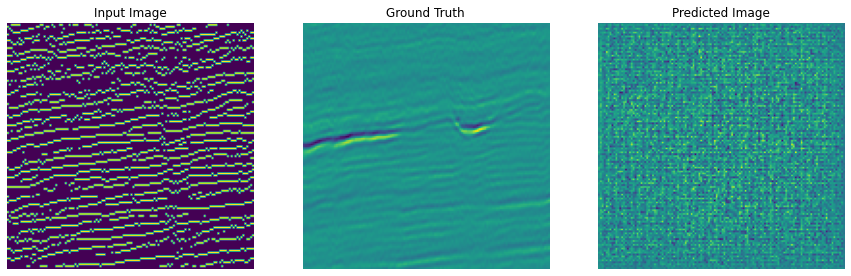

In [41]:
for example_input, example_target in valid_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [42]:
log_dir="/h1/bhoon/20220725_pix2pix_compare/p1/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [43]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [44]:
def fit(train_ds, test_ds, steps, save=None):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    idx = 1
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)

        # Save (checkpoint) the model every 0.05k steps
        if (step + 1) % 50 == 0:
            # checkpoint.save(file_prefix=checkpoint_prefix)
            if save:
                generator.save("/h1/bhoon/20220725_pix2pix_compare/p1/G_{}.h5".format(str(idx*50).zfill(5)))
                idx += 1

Time taken for 1000 steps: 132.52 sec



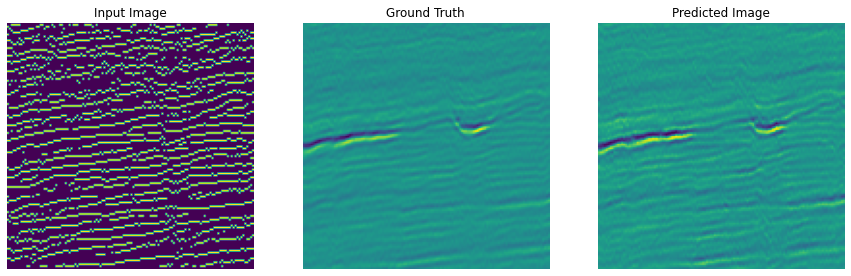

Step: 4k


In [45]:
fit(train_dataset, valid_dataset, steps=5000, save=True) 

In [46]:
def show_grid(data,r=4,c=4,jump=1,title='',save='',cmap='gray'):
    plt.figure(figsize=(c*2+1,r*2+1))
    i = 1
    for j in range(0,len(data),jump):
        dat = data[j]
        plt.subplot(r, c, i) 
        plt.imshow(dat, cmap=cmap)
        plt.axis('off')
        i+=1
        if i > r*c: break
    if title:
        plt.suptitle(title)
    if save:
        plt.savefig(save, bbox_inches='tight', pad_inches=0)
        plt.close()
    plt.show()

In [47]:
predOUT = generator.predict(validIN)
predOUT.shape

(481, 128, 128, 1)

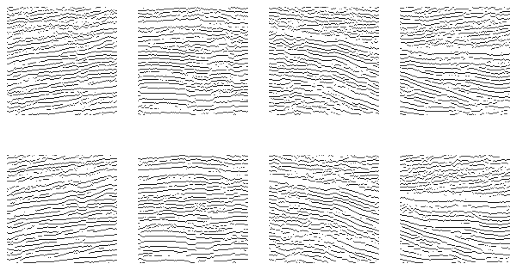

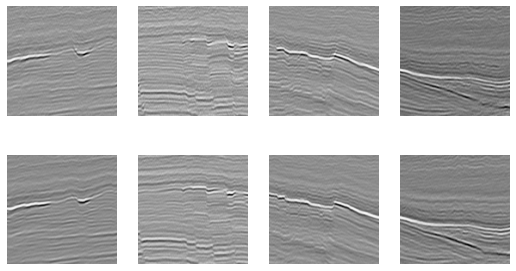

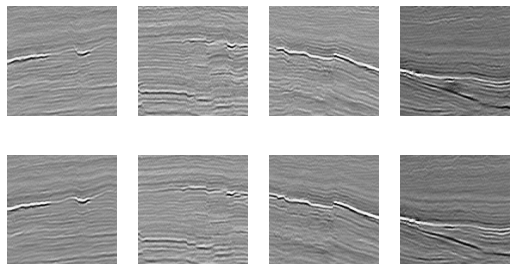

In [48]:
show_grid(validIN,2,4,cmap='Greys')
show_grid(validGT,2,4,cmap='Greys')
show_grid(predOUT,2,4,cmap='Greys')